<a href="https://colab.research.google.com/github/sezaionurlu/CLTV-Forecast-with-BG-NBD-and-Gamma-Gamma/blob/main/BG_NBD_ve_Gamma_Gamma_ile_CLTV_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################
# BG-NBD ve Gamma-Gamma ile CLTV Tahmini
##############################################################

**İş Problemi**

FLO satış ve pazarlama faaliyetleri için roadmap
belirlemek istemektedir. Şirketin orta uzun vadeli plan
yapabilmesi için var olan müşterilerin gelecekte şirkete
sağlayacakları potansiyel değerin tahmin edilmesi
gerekmektedir.

**Veri Seti Hikayesi**

Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan)
olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır.

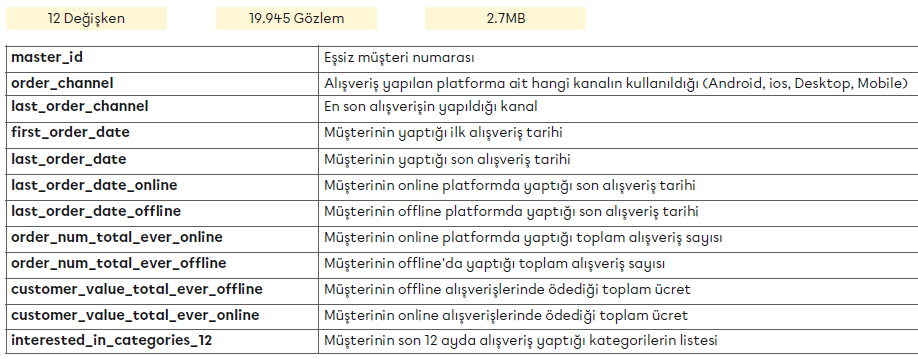

**Proje Görevleri**

*Görev 1: Veriyi Hazırlama*

In [ ]:
# Adım 1: flo_data_20K.csv verisini okuyunuz. 

In [ ]:
df_ = pd.read_csv('/content/drive/MyDrive/Veri Bilimi/Ödevler/3/flo_data_20k.csv')

In [ ]:
df = df_.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [ ]:
# Adım 2: Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız.
# Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız

In [ ]:
?round()

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return round(low_limit, ndigits=0), round(up_limit, ndigits=0)

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
# Adım 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline",
# "customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayanız.

In [ ]:
replace_with_thresholds(df,'order_num_total_ever_online')
replace_with_thresholds(df,'order_num_total_ever_offline')
replace_with_thresholds(df,'customer_value_total_ever_offline')
replace_with_thresholds(df,'customer_value_total_ever_online')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.0920,3.8095,1.0000,1.0000,2.0000,4.0000,48.0000
order_num_total_ever_offline,19945.0000,1.8862,1.4347,1.0000,1.0000,1.0000,2.0000,16.0000
customer_value_total_ever_offline,19945.0000,251.9213,251.0237,10.0000,99.9900,179.9800,319.9700,3020.0000
customer_value_total_ever_online,19945.0000,489.7057,632.6098,12.9900,149.9800,286.4600,578.4400,7800.0000


In [ ]:
# Adım 4: Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. Her bir müşterinin toplam
# alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.

In [ ]:
df['order_num_total_ever'] = df['order_num_total_ever_offline'] + df['order_num_total_ever_online']
df['customer_value_total_ever'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online']

In [ ]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total_ever,customer_value_total_ever
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],2.0000,209.9800


In [ ]:
# Adım 5: Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.

In [ ]:
for col in df.loc[:,df.columns.str.contains('date')]:
  df[col] = df[col].astype('datetime64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

*Görev 2: CLTV Veri Yapısının Oluşturulması*

In [ ]:
# Adım 1: Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.

In [ ]:
df['last_order_date'].max()

Timestamp('2021-05-30 00:00:00')

In [ ]:
today_date = dt.datetime(2021, 6, 1)

In [ ]:
today_date

datetime.datetime(2021, 6, 1, 0, 0)

In [ ]:
# Adım 2: customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz.
# Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.

In [ ]:
# recency: Son satın alma - ilk satın alma farkı. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç

In [ ]:
cltv_df = df.groupby('master_id').agg(
    {'last_order_date': [lambda last_order_date: (last_order_date.max() - df['first_order_date'].min()).days,
                     lambda last_order_date: (today_date - df['first_order_date'].min()).days],
     'order_num_total_ever': lambda order_num_total_ever: order_num_total_ever.sum(),
     'customer_value_total_ever': lambda customer_value_total_ever: customer_value_total_ever.sum()})

In [ ]:
cltv_df.head()

last_order_date            order_num_total_ever customer_value_total_ever
                                          <lambda_0> <lambda_1>             <lambda>                  <lambda>
master_id                                                                                                     
00016786-2f5a-11ea-bb80-000d3a38a36f            3050       3060               5.0000                  776.0700
00034aaa-a838-11e9-a2fc-000d3a38a36f            2762       3060               3.0000                  269.4700
000be838-85df-11ea-a90b-000d3a38a36f            2847       3060               4.0000                  722.6900
000c1fe2-a8b7-11ea-8479-000d3a38a36f            3033       3060               7.0000                  874.1600
000f5e3e-9dde-11ea-80cd-000d3a38a36f            3040       3060               7.0000                 1620.3300

In [ ]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [ ]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,3050,3060,5.0000,776.0700
00034aaa-a838-11e9-a2fc-000d3a38a36f,2762,3060,3.0000,269.4700
000be838-85df-11ea-a90b-000d3a38a36f,2847,3060,4.0000,722.6900
000c1fe2-a8b7-11ea-8479-000d3a38a36f,3033,3060,7.0000,874.1600
000f5e3e-9dde-11ea-80cd-000d3a38a36f,3040,3060,7.0000,1620.3300


In [ ]:
cltv_df = cltv_df.reset_index()

In [ ]:
cltv_df.head()

,master_id,<lambda_0>,<lambda_1>,<lambda>,<lambda>
0,00016786-2f5a-11ea-bb80-000d3a38a36f,3050,3060,5.0000,776.0700
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,2762,3060,3.0000,269.4700
2,000be838-85df-11ea-a90b-000d3a38a36f,2847,3060,4.0000,722.6900
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,3033,3060,7.0000,874.1600
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,3040,3060,7.0000,1620.3300


In [ ]:
cltv_df.columns = ['customer_id', 'recency_cltv_weekly', 'T_weekly', 'frequency', 'monetary_cltv_avg']

In [ ]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,00016786-2f5a-11ea-bb80-000d3a38a36f,3050,3060,5.0000,776.0700
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,2762,3060,3.0000,269.4700
2,000be838-85df-11ea-a90b-000d3a38a36f,2847,3060,4.0000,722.6900
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,3033,3060,7.0000,874.1600
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,3040,3060,7.0000,1620.3300


In [ ]:
cltv_df['monetary_cltv_avg'] = cltv_df['monetary_cltv_avg'] / cltv_df['frequency']
cltv_df['recency_cltv_weekly'] = cltv_df['recency_cltv_weekly'] / 7
cltv_df['T_weekly'] = cltv_df['T_weekly'] / 7

In [ ]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,00016786-2f5a-11ea-bb80-000d3a38a36f,435.7143,437.1429,5.0000,155.2140
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,394.5714,437.1429,3.0000,89.8233
2,000be838-85df-11ea-a90b-000d3a38a36f,406.7143,437.1429,4.0000,180.6725
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,433.2857,437.1429,7.0000,124.8800
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,434.2857,437.1429,7.0000,231.4757


In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.0000,417.9345,14.7544,384.7143,408.2857,421.2857,431.0000,436.8571
T_weekly,19945.0000,437.1429,0.0000,437.1429,437.1429,437.1429,437.1429,437.1429
frequency,19945.0000,4.9781,4.1209,2.0000,3.0000,4.0000,6.0000,57.0000
monetary_cltv_avg,19945.0000,152.0990,73.5241,22.4900,103.6533,136.9062,182.4500,1401.8000


*Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması*

In [ ]:
# Adım 1: BG/NBD modelini fit ediniz
# * 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv dataframe'ine ekleyiniz.
# * 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv dataframe'ine ekleyiniz

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 309.95, b: 0.00, r: 3.53>

In [ ]:
cltv_df['exp_sales_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(3*4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])

In [ ]:
cltv_df['exp_sales_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(6*4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency_cltv_weekly'],
                                                        cltv_df['T_weekly'])

In [ ]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,00016786-2f5a-11ea-bb80-000d3a38a36f,435.7143,437.1429,5.0000,155.2140,0.1370,0.2741
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,394.5714,437.1429,3.0000,89.8233,0.1049,0.2098
2,000be838-85df-11ea-a90b-000d3a38a36f,406.7143,437.1429,4.0000,180.6725,0.1210,0.2419
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,433.2857,437.1429,7.0000,124.8800,0.1692,0.3383
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,434.2857,437.1429,7.0000,231.4757,0.1692,0.3383


In [ ]:
# Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv dataframe'ine ekleyiniz.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [ ]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary_cltv_avg'])

In [ ]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,00016786-2f5a-11ea-bb80-000d3a38a36f,435.7143,437.1429,5.0000,155.2140,0.1370,0.2741,160.1171
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,394.5714,437.1429,3.0000,89.8233,0.1049,0.2098,95.2345
2,000be838-85df-11ea-a90b-000d3a38a36f,406.7143,437.1429,4.0000,180.6725,0.1210,0.2419,187.6809
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,433.2857,437.1429,7.0000,124.8800,0.1692,0.3383,127.7928
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,434.2857,437.1429,7.0000,231.4757,0.1692,0.3383,236.3683


In [ ]:
# Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz
# * Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.

In [ ]:
cltv_df['cltv'] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [ ]:
cltv_df.sort_values('cltv', ascending=False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
19124,f59053e2-a503-11e9-a2fc-000d3a38a36f,387.8571,437.1429,7.0000,1106.4671,0.1692,0.3383,1127.6115,400.2675
8869,7137a5c0-7aad-11ea-8f20-000d3a38a36f,430.1429,437.1429,11.0000,758.0855,0.2334,0.4668,767.3606,375.8479
5603,47a642fe-975b-11eb-8c2a-000d3a38a36f,432.1429,437.1429,4.0000,1401.8000,0.1210,0.2419,1449.0605,367.8461
7713,625f40a2-5bd2-11ea-98b0-000d3a38a36f,436.8571,437.1429,16.0000,501.8737,0.3137,0.6274,506.1667,333.2210
9080,73fd19aa-9e37-11e9-9897-000d3a38a36f,435.1429,437.1429,49.0000,184.9747,0.8438,1.6876,185.5412,328.5228
19631,fc0ce7a4-9d87-11e9-9897-000d3a38a36f,408.2857,437.1429,20.0000,393.2485,0.3780,0.7559,395.9796,314.0698
12855,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,432.5714,437.1429,52.0000,166.2246,0.8920,1.7839,166.7123,312.0414
2704,21d218f4-a91a-11e9-a2fc-000d3a38a36f,430.2857,437.1429,22.0000,356.8177,0.4101,0.8202,359.0865,309.0149
7280,5d1c466a-9cfd-11e9-9897-000d3a38a36f,432.5714,437.1429,50.0000,169.6994,0.8598,1.7197,170.2155,307.1240
9952,7eed6468-4540-11ea-acaf-000d3a38a36f,436.2857,437.1429,27.0000,289.7641,0.4904,0.9808,291.2922,299.7653


*Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması*

In [ ]:
# Adım 1: 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz

In [ ]:
cltv_df['segment'] = pd.qcut(cltv_df['cltv'], 4, labels = ['D', 'C', 'B', 'A'])

In [ ]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,segment
0,00016786-2f5a-11ea-bb80-000d3a38a36f,435.7143,437.1429,5.0000,155.2140,0.1370,0.2741,160.1171,46.0428,B
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,394.5714,437.1429,3.0000,89.8233,0.1049,0.2098,95.2345,20.9654,D
2,000be838-85df-11ea-a90b-000d3a38a36f,406.7143,437.1429,4.0000,180.6725,0.1210,0.2419,187.6809,47.6431,B
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,433.2857,437.1429,7.0000,124.8800,0.1692,0.3383,127.7928,45.3625,B
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,434.2857,437.1429,7.0000,231.4757,0.1692,0.3383,236.3683,83.9035,A


In [ ]:
# Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.

In [ ]:
cltv_df.groupby('segment').agg(
    {"count", "mean", "sum"})

recency_cltv_weekly                       T_weekly                       frequency                   monetary_cltv_avg                       exp_sales_3_month                 exp_sales_6_month                  exp_average_value                        cltv                    
                      count     mean          sum    count     mean          sum     count   mean        sum             count     mean          sum             count   mean      sum             count   mean       sum             count     mean          sum count    mean         sum
segment                                                                                                                                                                                                                                                                                    
D                      4988 415.3866 2071948.4286     4988 437.1429 2180468.5714      4988 2.9860 14894.0000              4988  88.3770  440824.2985              4988 0.1047 522.1611              4988 0.2094 1044.3221              4988  94.6310  472019.2997  4988 20.3974 101741.9843
C                      4986 416.8842 2078584.5714     4986 437.1429 2179594.2857      4986 3.8584 19238.0000              4986 129.6172  646271.6001              4986 0.1187 591.8224              4986 0.2374 1183.6448              4986 136.7491  681831.1637  4986 32.4849 161969.6703
B                      4985 418.2554 2085003.2857     4985 437.1429 2179157.1429      4985 4.7825 23841.0000              4985 167.0764  832875.7565              4985 0.1335 665.7006              4985 0.2671 1331.4013              4985 174.7923  871339.6561  4985 45.5730 227181.3671
A                      4986 421.2129 2100167.7143     4986 437.1429 2179594.2857      4986 8.2864 41316.0000              4986 223.3540 1113643.0715              4986 0.1898 946.4467              4986 0.3796 1892.8934              4986 230.8107 1150822.2951  4986 80.6490 402115.7199

In [ ]:
# C ve D grupları birleştirip tek bir C grubu gibi düşünebiliriz.
# A grubunun 6 ayda ort. beklenen satış adeti diğer grupların neredeyse 2şer katı kadar. Ort getirisi ise 3 grubun toplamının yarısı kadar